In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy.spatial import Delaunay

In [2]:
def gaussQuadStd1d(g, noOfIntegPt):
    """
    TASK   - Evaluate definite integral of G(ξ) from -1 to 1 using Gaussian quadrature

    INPUTS - g           : function representing the integrand
             noOfIntegPt : number of integration points
    OUTPUT - y           : value of integral
    """
    
    if noOfIntegPt == 2:
        weights = [1.0, 1.0]
        points = [-1/(3**0.5), 1/(3**0.5)]
    elif noOfIntegPt == 3:
        weights = [5/9, 8/9, 5/9]
        points = [-((3/5)**0.5), 0.0, ((3/5)**0.5)]
    elif noOfIntegPt == 4:
        points = [
            -np.sqrt((3 + 2*np.sqrt(6/5))/7),
            -np.sqrt((3 - 2*np.sqrt(6/5))/7),
            np.sqrt((3 - 2*np.sqrt(6/5))/7),
            np.sqrt((3 + 2*np.sqrt(6/5))/7)
        ]
        weights = [
            (18 - np.sqrt(30))/36,
            (18 + np.sqrt(30))/36,
            (18 + np.sqrt(30))/36,
            (18 - np.sqrt(30))/36
        ]
    elif noOfIntegPt == 5:
        points = [
            -np.sqrt(5 + 2*np.sqrt(10/7))/3,
            -np.sqrt(5 - 2*np.sqrt(10/7))/3,
            0.0,
            np.sqrt(5 - 2*np.sqrt(10/7))/3,
            np.sqrt(5 + 2*np.sqrt(10/7))/3
        ]
        weights = [
            (322 - 13*np.sqrt(70))/900,
            (322 + 13*np.sqrt(70))/900,
            128/225,
            (322 + 13*np.sqrt(70))/900,
            (322 - 13*np.sqrt(70))/900
        ]
    else:
        raise ValueError("Only 2, 3, 4 or 5 integration points are supported.")

    integral = 0.0
    for i in range(len(points)):
        integral += weights[i] * g(points[i])
        
    return integral

In [3]:
def gaussQuad1d(fn, lowerLimit, upperLimit, noOfIntegPt):
    """
    TASK   - Evaluate definite integral of fn(x) from lowerLimit to upperLimit using Gaussian quadrature

    INPUTS - fn          : function representing the integrand
             lowerLimit  : lower integration limit (a)
             upperLimit  : upper integration limit (b)
             noOfIntegPt : number of integration points
    OUTPUT - y           : value of integral
    """
    
    def transform(xi):
        return 0.5 * (upperLimit - lowerLimit) * xi + 0.5 * (upperLimit + lowerLimit)

    def transformedfn(xi):
        x = transform(xi)
        return ((upperLimit - lowerLimit)/2) * fn(x)

    return gaussQuadStd1d(transformedfn, noOfIntegPt)

In [4]:
def midPtCurve(f, fder, x1, x2):
    """
    TASK - Find midpoint of curve segment from (x1, y1) to (x2, y2) when curve is described by y = f(x)
    
    INPUTS
    f      : curve function y = f(x)
    fder   : derivative of f(x)
    x1, x2 : x-coordinates of the endpoints
    
    OUTPUTS
    xm, ym : (x,y)-coordinates of the midpoint
    """
    
    # Define integrand for arc length
    def integrand(t):
        return np.sqrt(1 + fder(t)**2)
    
    # Calculate total arc length L from x1 to x2
    L = gaussQuad1d(integrand, x1, x2, 5)
    
    # Define function whose root we need to find
    def m(x):
        partial_length = gaussQuad1d(integrand, x1, x, 5)
        return partial_length - L/2
    
    # Find root of m(x)
    result = root_scalar(m, bracket=[x1, x2], method='brentq')
    xm = result.root
    ym = f(xm)
    
    return xm, ym

In [5]:
f1    = lambda x: x**3 - 5*x
f1der = lambda x: 3*x**2 - 5
x1 = -12.4
x2 = -8.12
xm, ym = midPtCurve(f1,f1der,x1,x2)
print(f'mid point = ({xm},{ym})')

mid point = (-10.694564602547155,-1169.7042292113642)


In [6]:
f2    = lambda x: np.cos(x) - 0.22*x**3
f2der = lambda x: -np.sin(x) - 0.66*x**2
x1 = -1
x2 = 0.5
xm, ym = midPtCurve(f2,f2der,x1,x2)
print(f'mid point = ({xm},{ym})')

mid point = (-0.24923352906554339,0.972507744937423)


In [7]:
def delaunayMesh(nodes):
    """
    TASK - Generates a Delaunay mesh for a quadrilateral domain 

    INPUT
    nodes     : 2D array where 2 columns represent x- and y- coordinates of nodes
    
    OUTPUTS
    triangles : 2D array with 3 columns (in e-th row, 3 vertices of the e-th element are listed)
    edges     : 2D array with 2 columns (in each row, 2 vertices of one edge is listed)
    bdyNode   : array detecting if node is on boundary (boolean)
    bdyEdge   : array detecting if edge is on boundary (boolean) 
    """
    # Delaunay triangulation
    tri = Delaunay(nodes)
    triangles = tri.simplices + 1
    
    # Collect all edges from triangles 
    edge_counts = {}
    for tri_indices in tri.simplices:
        # Get three edges from each triangle
        edges = [
            tuple(sorted((tri_indices[0], tri_indices[1]))),
            tuple(sorted((tri_indices[1], tri_indices[2]))),
            tuple(sorted((tri_indices[2], tri_indices[0])))
        ]
        for edge in edges:
            edge_counts[edge] = edge_counts.get(edge, 0) + 1
    
    # Remove duplicate edges
    unique_edges = [list(edge) for edge in edge_counts.keys()]
    unique_edges_1based = np.array(unique_edges) + 1
    
    # Sort edges
    max_node = np.max(triangles)
    ordered_edges = []
    
    for node in range(1, max_node + 1):
        # Edges where node is first
        node_edges = [edge for edge in unique_edges_1based if edge[0] == node]
        node_edges.sort(key=lambda x: x[1])
        ordered_edges.extend(node_edges)
        
        # Edges where node is second
        node_edges = [edge for edge in unique_edges_1based if edge[1] == node and edge[0] > node]
        node_edges.sort(key=lambda x: x[0])
        ordered_edges.extend(node_edges)
    
    edges = np.array(ordered_edges)
    
    # Create mapping from edges to their index in unique_edges
    edge_to_index = {edge: i for i, edge in enumerate(edge_counts.keys())}
    
    # Determine boundary edges
    bdyEdge = np.zeros(len(edges), dtype=bool)
    for i, edge in enumerate(unique_edges_1based):
        edge_0based = tuple(np.array(edge) - 1)
        if edge_counts[edge_0based] == 1:
            # Find where this edge appears in the ordered edges
            idx = np.where((edges == edge).all(axis=1))[0][0]
            bdyEdge[idx] = True
    
    # Determine boundary nodes
    bdyNode = np.zeros(len(nodes), dtype=bool)
    for i, (n1, n2) in enumerate(edges):
        if bdyEdge[i]:
            bdyNode[n1-1] = True
            bdyNode[n2-1] = True
    
    return triangles, edges, bdyNode, bdyEdge

triangle = [[2 4 9]
 [4 2 3]
 [8 2 9]
 [2 8 1]
 [4 6 9]
 [6 4 5]
 [6 8 9]
 [8 6 7]]
edges = [[1 2]
 [1 8]
 [2 3]
 [2 4]
 [2 8]
 [2 9]
 [3 4]
 [4 5]
 [4 6]
 [4 9]
 [5 6]
 [6 7]
 [6 8]
 [6 9]
 [7 8]
 [8 9]]
bdyNode = [ True  True  True  True  True  True  True  True False]
bdyEdge = [ True  True  True False False False  True  True False False  True  True
 False False  True False]


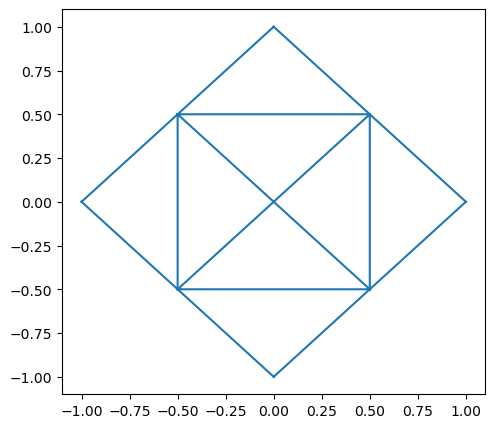

In [8]:
nodes1 = np.array([[-1,0],[-0.5,-0.5],[0,-1],[0.5,-0.5],\
[1,0],[0.5,0.5],[0,1],[-0.5,0.5],[0,0]])
triangles1,edges1,bdyNode1,bdyEdge1 = delaunayMesh(nodes1)
print(f'triangle = {triangles1}')
print(f'edges = {edges1}')

print(f'bdyNode = {bdyNode1}')
print(f'bdyEdge = {bdyEdge1}')

# Plot initial triangulation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.triplot(nodes1[:, 0], nodes1[:, 1], triangles1-1)


In [9]:
# refine the domain but dividing each triangle to 3 triangles
def refine(nodes,triangles,edges,bdyNode,bdyEdge,curveEdge,bdyFn,bdyFnder):
    '''
    Refine a domain

    nodes,triangles,edges,bdyNode,bdyEdge,curveEdge =refine(nodes,triangles,edges,bdyNode,bdyEdge,curveEdge,bdyFn,bdyFnder)

    this program refines a triangulation using standard refinement 
    input and output:
    nodes - 2-column array that stores the (x,y)-coordinates of nodes
    trangles - 3-column array that stores the nodes in each triangle
    edges - 2-column array that stores the end nodes of edges
    bdyNode - 1D array that indicates if a node is a boundary node  
    bdyEdge - 1D array that indicates if an edge is a boundary edge 
    curveEdge - 1D array that indicates if an edge is an approximation of a curve 
    bdyFn - a function represents the function that describe the boundary
    bdyFnder - the derivative of the boundary function
    
    '''
    
    noTri = np.shape(triangles)[0] # no of triangles
    noNode = np.shape(nodes)[0] # no of nodes
    parentNodes = np.array([]).reshape((0,2))   # track where the midpoint is from

    # go through triangles to get midpoints
    for k in range(0,noTri):
        node1 = triangles[k,0]
        node2 = triangles[k,1]
        node3 = triangles[k,2]
    
        # check the first edge
        inEdges = (np.sum((edges == node1)+(edges == node2),axis=1)==2) # find where the first edge is in the edge list
        if (np.sum(inEdges)): # if found
            edgeNo = np.where(inEdges)[0] # which edge it is

            # find midpoint
            if (curveEdge[edgeNo[0]] == 1):  # if it is a curve edge
                x1m,y1m = midPtCurve(bdyFn,bdyFnder,nodes[node1-1,0],nodes[node2-1,0])
            else:
                x1m = 0.5*(nodes[node1-1,0]+nodes[node2-1,0])
                y1m = 0.5*(nodes[node1-1,1]+nodes[node2-1,1])
            # endif curveEdge
            
            nodes,edges,bdyNode,bdyEdge,curveEdge = updateTri(x1m,y1m,node1,node2,edgeNo,nodes,edges,bdyNode,bdyEdge,curveEdge)
            numNode = len(nodes[:,0])
            nodeNo4MidPt1 = numNode # record the node number of the 1st midpoint
            parentNodes = np.vstack((parentNodes,[node1,node2])) # record the parents that produce this midpoints
                    
        else: # not in existing edges
            # find the node number for the 1st midpoint
            nodeNo4MidPt1 = noNode + np.where(np.sum((parentNodes==node1)+(parentNodes==node2),axis=1)==2)[0][0]+1
        # endif inEdges
            
    
        # check the second edge
        inEdges = (np.sum((edges==node2)+(edges==node3),axis=1)==2) # find where the second edge is in the edge list
        if (np.sum(inEdges)): # if found
            edgeNo = np.where(inEdges)[0] # which edge it is
        
            # find midpoint
            if (curveEdge[edgeNo[0]] == 1): # if it is a curve edge
                x2m,y2m = midPtCurve(bdyFn,bdyFnder,nodes[node2-1,0],nodes[node3-1,0])
            else:
                x2m = 0.5*(nodes[node2-1,0]+nodes[node3-1,0])
                y2m = 0.5*(nodes[node2-1,1]+nodes[node3-1,1])
            # endif curveEdge
            
            nodes,edges,bdyNode,bdyEdge,curveEdge = updateTri(x2m,y2m,node2,node3,edgeNo,nodes,edges,bdyNode,bdyEdge,curveEdge)
            numNode = len(nodes[:,0])
            nodeNo4MidPt2 = numNode # record the node number of the 2nd midpoint
            parentNodes = np.vstack((parentNodes,[node2, node3])) # record the parents that produce this midpoints
            
        else: # not in existing edges
            # find the node number for the 2nd midpoint
            nodeNo4MidPt2 = noNode + np.where(np.sum((parentNodes==node2)+(parentNodes==node3),axis=1)==2)[0][0]+1
        # endif inEdges
            

        # check the third edge
        inEdges = (np.sum((edges==node1)+(edges==node3),axis=1)==2) # find where the third edge is in the edge list
        if (np.sum(inEdges)): # if found
            edgeNo = np.where(inEdges)[0] # which edge it is
        
            # find midpoint
            if (curveEdge[edgeNo[0]] == 1): # if it is a curve edge
                x3m,y3m = midPtCurve(bdyFn,bdyFnder,nodes[node1-1,0],nodes[node3-1,0])
            else:
                x3m = 0.5*(nodes[node1-1,0]+nodes[node3-1,0])
                y3m = 0.5*(nodes[node1-1,1]+nodes[node3-1,1])
            # endif curveEdge
            
            nodes,edges,bdyNode,bdyEdge,curveEdge = updateTri(x3m,y3m,node1,node3,edgeNo,nodes,edges,bdyNode,bdyEdge,curveEdge)
            numNode = len(nodes[:,0])
            nodeNo4MidPt3 = numNode # record the node number of the 3rd midpoint
            parentNodes = np.vstack((parentNodes,[node1, node3])) # record the parents that produce this midpoints
            
        else: # not in existing edges
            # find the node number for the 3rd midpoint
            nodeNo4MidPt3 = noNode + np.where(np.sum((parentNodes==node1)+(parentNodes==node3),axis=1)==2)[0][0]+1
        # endif inEdges
        
  
        # put the 3 new edges in (cnnecting 3 midpoints)
        edges = np.vstack((edges,[[nodeNo4MidPt1, nodeNo4MidPt2],[nodeNo4MidPt2, nodeNo4MidPt3],[nodeNo4MidPt1, nodeNo4MidPt3]]))
        bdyEdge = np.hstack((bdyEdge,[0,0,0]))
        curveEdge = np.hstack((curveEdge,[0,0,0]))

        # replace this triangle in the triangle list by 4 new triangles
        triangles[k,:] = np.array([node1, nodeNo4MidPt1, nodeNo4MidPt3])
        triangles = np.vstack((triangles,[node2, nodeNo4MidPt2, nodeNo4MidPt1]))
        triangles = np.vstack((triangles,[node3, nodeNo4MidPt3, nodeNo4MidPt2]))
        triangles = np.vstack((triangles,[nodeNo4MidPt1, nodeNo4MidPt2, nodeNo4MidPt3]))
    # endfor all triangles

    return nodes, triangles, edges, bdyNode, bdyEdge, curveEdge
#####################


# update triangles and nodes, used in refine
def updateTri(xm,ym,parentNode1,parentNode2,edgeNo,nodes,edges,bdyNode,bdyEdge,curveEdge):
    '''
    The function that updates nodes, edges, bdyNode, bdyEdge, curveEdge when doing refinement

    [nodes,edges,bdyNode,bdyEdge,curveEdge] = updateTri(xm,ym,parentNode1,parentNode2,edgeNo,nodes,edges,bdyNode,bdyEdge,curveEdge)

    Chung-min Lee Mar 26, 2025
    '''

    # add the midpoint to nodes
    nodes = np.vstack((nodes, [xm, ym]))
    row = len(nodes[:,1])

    # replace the original edge by 2 new edges
    edges[edgeNo,:] = np.array([parentNode1, row])
    edges = np.vstack((edges,[parentNode2, row]))

    # if the parent nodes are on a bdyEdge, then this midpoint is a boundary
    # node and both new edges are boundary edges
    if (bdyEdge[edgeNo] == 1):
        bdyNode = np.hstack((bdyNode,[1]))
        bdyEdge = np.hstack((bdyEdge,[1]))
    else:
        bdyNode = np.hstack((bdyNode,[0]))
        bdyEdge = np.hstack((bdyEdge,[0]))
    # endif boundary edge

    # update curveEdge for two new edges
    if (curveEdge[edgeNo] == 1):
        curveEdge = np.hstack((curveEdge,[1]))
    else:
        curveEdge = np.hstack((curveEdge,[0]))
    # endif curveEdge
    
    return nodes,edges,bdyNode,bdyEdge,curveEdge


In [10]:
def triangle_quality(nodes, triangles):
    """
    TASK -  Calculate q1(T) = (sqrt(3) * d_T) / diam(T) for each triangle
                where: d_T     -> diameter of the inscribed circle
                       diam(T) -> diameter of the circumscribed circle
    INPUTS
    nodes     : 2D array where 2 columns represent x- and y- coordinates of nodes
    triangles : 2D array with 3 columns (in e-th row, 3 vertices of the e-th element are listed)

    OUTPUT
    min(qualities) : Quality of triangulation by selecting the minimum value calculated in q1(T)
    
    """
    
    qualities = []
    
    for tri in triangles:
        # Collect the three vertices
        A, B, C = nodes[tri[0]-1], nodes[tri[1]-1], nodes[tri[2]-1]
        
        # Calculate side lengths
        a = np.linalg.norm(B - C)
        b = np.linalg.norm(A - C)
        c = np.linalg.norm(A - B)

        # Diameter of inscribed circle 
        s = (a + b + c) / 2
        d_T = 2 * np.sqrt( ((s-a)*(s-b)*(s-c)) / s )
        
        # Diameter of circumscribed circle
        diam_T = np.max(np.array([a, b, c]))

        # Calculate quality measure
        q1 = (np.sqrt(3) * d_T) / diam_T
        qualities.append(q1)
    
    return np.min(qualities)

Initial minimum triangle quality q1(T): 0.6699
Refined minimum triangle quality q1(T): 0.6563


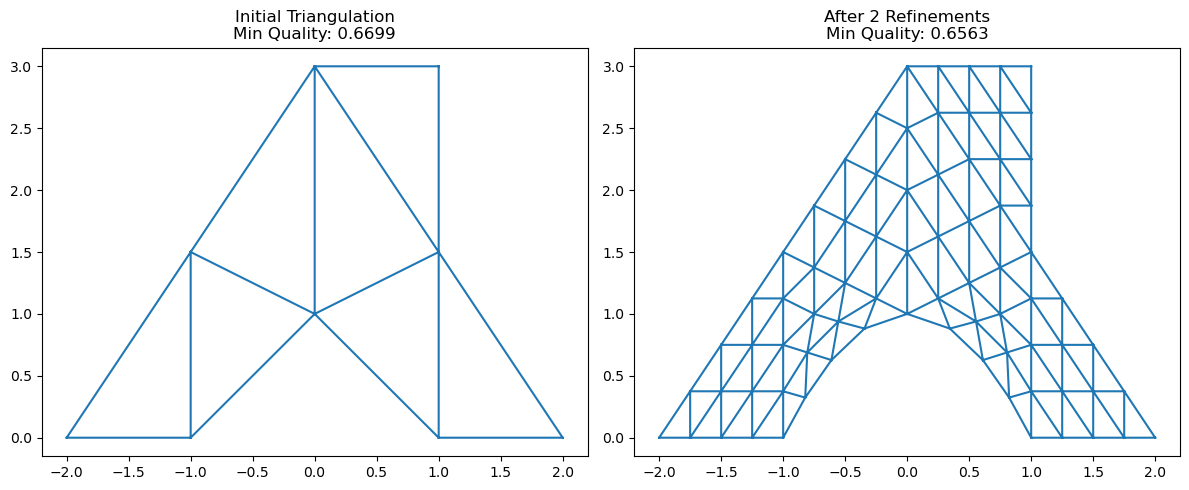

In [11]:
# PROBLEM 3

# Part (a) - Quality of Initial Triangulation 

nodes     = np.array([[-2, 0], [-1, 0], [0, 1], [1, 0], [2, 0], [1, 1.5], [1, 3], [0, 3], [-1, 1.5]])
triangles = np.array([[1, 2, 9], [2, 3, 9], [3, 4, 6], [4, 5, 6], [6, 7, 8], [3, 6, 8], [3, 8, 9]])
edges     = np.array([[1, 2], [1, 9], [2, 3], [2, 9], [3, 4], [3, 6], [3, 8], [3, 9], [4, 5], [4, 6], [5, 6], [6, 7], [6, 8], [7, 8], [8, 9]])
bdyNode   = np.ones(9, dtype=bool)
bdyEdge   = np.array([1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1], dtype=bool)
curveEdge = np.array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=bool)

# Calculate initial quality
initial_quality = triangle_quality(nodes, triangles)
print(f"Initial minimum triangle quality q1(T): {initial_quality:.4f}")


# Part (b) - Refined Triangulation and Plot

# Define boundary function and its derivative
bdyFn    = lambda x: 1 - x**2
bdyFnder = lambda x: -2*x

# Plot initial triangulation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.triplot(nodes[:, 0], nodes[:, 1], triangles-1)
plt.title(f"Initial Triangulation\nMin Quality: {initial_quality:.4f}")

# First refinement
nodes1, triangles1, edges1, bdyNode1, bdyEdge1, curveEdge1 = refine(
    nodes.copy(), triangles.copy(), edges.copy(), 
    bdyNode.copy(), bdyEdge.copy(), curveEdge.copy(), 
    bdyFn, bdyFnder)

# Second refinement
nodes2, triangles2, edges2, bdyNode2, bdyEdge2, curveEdge2 = refine(
    nodes1.copy(), triangles1.copy(), edges1.copy(), 
    bdyNode1.copy(), bdyEdge1.copy(), curveEdge1.copy(), 
    bdyFn, bdyFnder)

# Calculate quality after refinement
refined_quality = triangle_quality(nodes2, triangles2)
print(f"Refined minimum triangle quality q1(T): {refined_quality:.4f}")

# Plot refined triangulation
plt.subplot(1, 2, 2)
plt.triplot(nodes2[:, 0], nodes2[:, 1], triangles2-1) 
plt.title(f"After 2 Refinements\nMin Quality: {refined_quality:.4f}")
plt.tight_layout()
plt.show()